# Handwritten Digits Recognizer Using Two (2) - Layer Neural Network

In this notebook, I built a basic two-layer neural network from scratch. I trained it on the MNIST handwritten digits dataset. The main goal was to understand the math behind neural networks:

- Forward and backward propagation
- Activations
- Loss functions
- Gradient updates

# Importing Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import sklearn


# Loading Train Data

In [11]:
train = pd.read_csv("train.csv")


# Loading Test Data

In [12]:
test = pd.read_csv("test.csv")



# Data Visualization

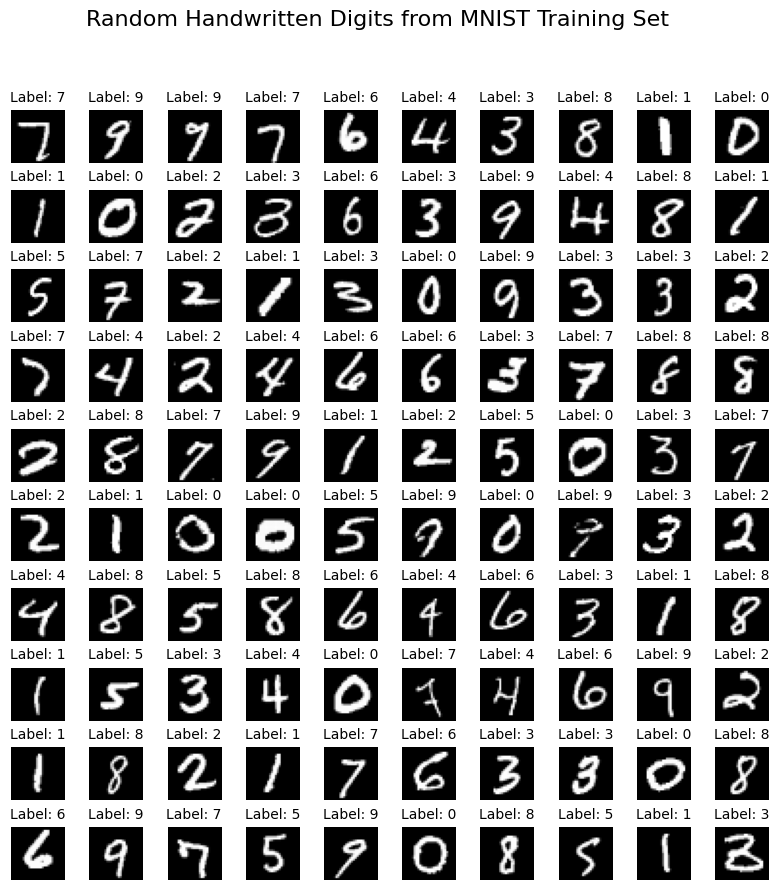

In [13]:
# Visualize 10x10 random digits from the training set
rows = 10
cols = 10
fig = plt.figure(figsize=(10, 10))  # Larger figure for better visibility

# Randomly select 100 examples
indexes = np.random.choice(len(train), rows * cols, replace=False)

count = 0
for i in range(rows):
    for j in range(cols):
        idx = indexes[count]
        ax = fig.add_subplot(rows, cols, count + 1)
        
        # Extract the pixel values and reshape to 28x28
        pixels = train.iloc[idx, 1:].values  # Skip the 'label' column
        pixels = pixels.reshape(28, 28)
        
        ax.imshow(pixels, cmap='gray')
        ax.set_title(f"Label: {train.iloc[idx, 0]}", fontsize=10)
        ax.axis('off')
        
        count += 1

plt.subplots_adjust(wspace=0.1, hspace=0.5)  # Space for titles
plt.suptitle("Random Handwritten Digits from MNIST Training Set", fontsize=16)
plt.show()

# Checking First and last Five Rows of Train set

In [14]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
train.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train.shape

(42000, 785)

In the Table:

Row = number of examples (samples / images) (m)

Column = number of features (n)

Covert Data To Numpy Array & Shuffle it

In [36]:
data = np.array(train)

In [52]:
m, n = data.shape    

In [42]:
print(f"Number of examples (m): {m}")
print(f"Number of columns (n): {n}")

Number of examples (m): 42000
Number of columns (n): 785


# Split data into Val set and Train set and Transpose

In [53]:
indices = np.random.permutation(m)

X = data[indices, 1:]  # Features (pixels) in random order, aligned with y
Y = data[indices, 0]   # Labels in the same random order (perfectly aligned with x)

In [54]:
n_dev = 1000

# Split using m and n_dev
X_dev   = X[:n_dev]        # first n_dev examples → validation features
y_dev   = Y[:n_dev]        # matching labels
X_train = X[n_dev:]        # remaining m - n_dev examples → training features
y_train = Y[n_dev:]        # matching labels


# Shape of X & Y

In [55]:
print("X.shape:", X.shape)   
print("y.shape:", y.shape)   
print("X_dev.shape:", X_dev.shape)     
print("y_dev.shape:", y_dev.shape)    
print("X_train.shape:", X_train.shape) 

X.shape: (42000, 784)
y.shape: (42000,)
X_dev.shape: (1000, 784)
y_dev.shape: (1000,)
X_train.shape: (41000, 784)


# Intitialize Parameters

In [56]:
def init_param(n_input, n_hidden, n_output):
    """
    Initialize weights and biases for a 2-layer neural network.
    
    Args:
        n_input: number of input features
        n_hidden: number of neurons in hidden layer
        n_output: number of output neurons/classes
    
    Returns:
        W1, b1, W2, b2: initialized parameters
    """
    # Input → Hidden
    W1 = np.random.randn(n_hidden, n_input) * 0.1  
    b1 = np.zeros((n_hidden, 1))       
                
    # Hidden → Output
    W2 = np.random.randn(n_output, n_hidden) * 0.1
    b2 = np.zeros((n_output, 1))
    
    return W1, b1, W2, b2


# Defining Variables


In [57]:
n_input = n - 1
n_hidden = 10
n_output = 10

In [58]:
W1, b1, W2, b2 = init_param(n_input, n_hidden, n_output)

print("W1:", W1.shape)
print("b1:", b1.shape)
print("W2:", W2.shape)
print("b2:", b2.shape)


W1: (10, 784)
b1: (10, 1)
W2: (10, 10)
b2: (10, 1)


# Activation 

- relu
- softmax

In [60]:
def relu(Z):
    """
    Z: numpy array of shape (n_output, m), m = number of examples
    Returns: softmax probabilities of same shape
    """
    return np.maximum(0,Z)


def softmax(Z):
    """
    Z: numpy array of shape (n_output, m), m = number of examples
    Returns: softmax probabilities of same shape
    """
    ez = np.exp(Z)
    return ez / np.sum(ez, axis = 0)

# Forward Propagation

In [ ]:
def forward_prop(W1, b1, W2, b2, X):
    """
    Forward propagation for a 2-layer neural network.
    
    Args:
        W1, b1: weights and biases for layer 1 (W1: (n_hidden, n_input))
        W2, b2: weights and biases for layer 2 (W2: (n_output, n_hidden))
        X: input data of shape (m, n_input)  ← examples in rows
    
    Returns:
        A2: output probabilities of shape (n_output, m)
        cache: dictionary with intermediates for backprop
    """
    # X shape: (m, 784) → transpose to (784, m) for matmul
    Z1 = W1 @ X.T + b1          # (10, 784) @ (784, m) → (10, m)
    A1 = relu(Z1)               # (10, m)
    
    Z2 = W2 @ A1 + b2           # (10, 10) @ (10, m) → (10, m)
    A2 = softmax(Z2)            # (10, m) 
    
    cache = {
        "Z1": Z1,   # (10, m)
        "A1": A1    # (10, m)
    }
    
    return A2, cache

# Backpropagation

In [ ]:
def back_prop(A2, cache, X, Y, W2):
    """
    Backpropagation for a 2-layer neural network
    (ReLU hidden layer + Softmax output layer)

    Inputs:
        A2    : softmax output probabilities, shape (n_output, m)
        cache : dictionary containing forward-pass values
               cache["A1"] -> activations from hidden layer (n_hidden, m)
               cache["Z1"] -> pre-activation of hidden layer (n_hidden, m)
        X     : input data, shape (m, n_input)
        Y     : true label, shape (n_output, m)
        W2    : weights of output layer, shape (n_output, n_hidden)

    Returns:
        dw1, db1 : gradients for W1 and b1
        dw2, db2 : gradients for W2 and b2
    """
    
    m = X.shape[0]
    # Retrieving values from cached 
    A1 = cache["A1"]     # (10, m)
    Z1 = cache["Z1"]     # (10, m)
    
    # Output layer gradients (Softmax + Cross-Entropy)
    
    # Gradient of loss wrt z2
    dz2 = A2 -Y
    
    # Gradient wrt w2
    dw2 = (1/m)*np.dot(dz2, A1.T)
    
    # Gradient wrt b2
    db2 = (1/m)*np.sum(dz2, axis=1, keepdims=True)
    
    

    # Hidden layer gradients (ReLu)
    dA1  = np.dot(W2.T, dz2)
    
    # Apply derivative of ReLu
    dz1 = dA1 * (Z1 > 0)
    
    dw1 = (1/m)*np.dot(dz1,X)
    
    db1 = (1/m)*np.sum(dz1, axis = 1, keepdims = True)
    
    grads = {
    "dW1": dw1,
    "db1": db1,
    "dW2": dw2,
    "db2": db2
}

    
    
    return grads

    
    

# Parameter updates

In [ ]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    
    W1 = W1 -learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    
    model = {
    "W1": W1,
    "b1": b1,
    "W2": W2,
    "b2": b2
}

    
    return model